   # Introduction

The objective of this project is to study and understand the impact of different variables on the movements of crude oil spot prices. We hope to then build a model that is capable of predicting oil price movements in the near and medium term. 

Or main source of data is is the Energy Information Agency's API, which provides a large variety of datasets related to the Eenergy industry. From this source, we will get the actual spot price data over time, as well as time series data for following variables: 

Weekly inventory levels: 

The amount of crude oil in storage in the US for a given week. This basically serves as our measure of supply. 

U.S. Weekly product supplied:

Measures the disappearance of petroleum products from primary sources; approximately represents consumption of petroleum products.

We will also incorporate the Dow Jones Industrial Average in order to evaluate the relationship between crude oil prices and the performance of the broader market.



In [1]:
!git add .
!git commit -m "precolab"
!git push

The file will have its original line endings in your working directory
[master efe4bbde] precolab
 1 file changed, 453 insertions(+), 58983 deletions(-)
 rewrite MainRedux.ipynb (99%)
To https://github.com/thekhan314/CrudeOilApp.git
   43c412f8..efe4bbde  master -> master


In [2]:
from datashop import *
from data_functions import *

import pprint as pp

import chart_studio.plotly as py

import plotly.offline as pyo
import plotly.graph_objs as go
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Capture 
eia_dict = {        
        'DailyPrice':['DailyPrice','PET.RWTC.D','241335','%Y%m%d'],
        'WeeklyStocks':['WeeklyStocks','PET.WTTSTUS1.W','235081','%Y%m%d'],
        'ProductSupplied':['ProductSupplied', 'PET.WRPUPUS2.W','401676','%Y%m%d']
    }

# Price

## Prelimnary assesment

Lets get the price data from the EIA, and study it by itself. We will try to find patterns in like like seasonality.



In [3]:
dprice = eia_dict['DailyPrice']

price = EIA_Series(
    dprice[1], 
    name = dprice[0],
    date_format=dprice[3],
    scale=True,
    end='20200101'
    )

#

data = [go.Scatter(x=price.scaled.index,
            y=price.scaled)]

fig = go.Figure(data)
fig.show()

## Assessing Trends and Cycles

## Trend and Cycles with Holdrick Prescott

Lets examien the trend and cycle components for the whole series. We will first use the holdrick prescott filter to isolate the trend and cyclical components of the time series. 

In [4]:
price_cycle,price_trend = hpfilter(price.scaled,lamb=1600)

price.frame['cycles'] = price_cycle
price.frame['trend'] = price_trend

data = [go.Scatter(x=price.scaled.index,
            y=price.scaled, name = "DailyPrice"),
        go.Scatter(x=price.frame.index,
            y=price.frame['cycles'],name='Cycle'),
        go.Scatter(x=price.frame.index,
            y=price.frame['trend'],name = 'Trend')
            ]

fig = go.Figure(data)

fig.show()

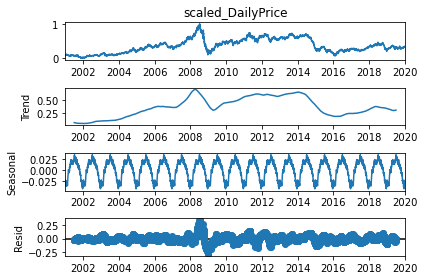

In [5]:
result = seasonal_decompose(
    price.scaled, 
    model='additive',
    period=365) 

result.plot();

The ETS plot shows us a few things that confirm our understanding of the evolution of oil price over time. 

The seasonality plot shows us that to some extent, the movement in oil prices is seasonal. This is probably due to increased demand during summer driving months or winter heating requirements. 

The error chart shows us the remaning movement, which cannot be explained by either the trends or the seasonality. And here we see again that there is more movement aorund 2008 and 2014 that cannot be explained by factors intrinsic to trends and seasonal fluctuations of oil. This confirms the idea that during these times, external factors strongly influences oil prices to move in unusual ways. 

## Exponentially weighted moving average

One of the ways to mitigate the effects of extreme historical values is to use exponentially weighted moving averages instead of simple moving averages when trying to isolate trend components. Lets apply that to our dataset. 

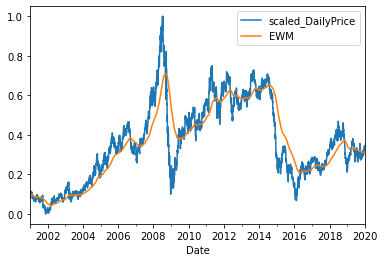

In [6]:
price.frame['EWM'] = price.frame["scaled_DailyPrice"].ewm(span=365).mean()
price.frame[['scaled_DailyPrice','EWM']].plot()

It seems that EWM is not entirely sufficient to reduce the impact of the outlier events on the series.

# Forecasting

Lets proceed with building models to forecast future models. we will start with the Holt Winters methods for modeling time series, then try ARIMA, SARIMAX and VAR. 

In [7]:
train = price.frame.loc[:'20191001']
test = price.frame.loc['20191002':]

first_model = ExponentialSmoothing(
    train['scaled_DailyPrice'],
    trend='add',
    seasonal='add',
    seasonal_periods= 365
    ).fit()
predictions = first_model.forecast(92)

data = [go.Scatter(x=predictions.index,
            y=predictions, name = "Predicted"),
        go.Scatter(x=test['scaled_DailyPrice'].index,
            y=test['scaled_DailyPrice'],name='Actual')]
fig = go.Figure(data)

fig.show()

mse_error = mean_squared_error(test['scaled_DailyPrice'],predictions)
rmse_error = rmse(test['scaled_DailyPrice'],predictions)

print("Mean Squared Error: {}".format(mse_error))
print("Root Mean Squared Error: {}".format(rmse_error))

C:\Users\umark\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Mean Squared Error: 0.0017705851864641662
Root Mean Squared Error: 0.042078322049057114


Our preliminary forecasting does not seem to be doing so well at first class. To an extent this was to be expected, since we have not yet factored in exogenous variables. 

## Holt Winters method

## ARIMA

## Stationarity

## Arima Order

In [10]:
auto_arima(price.scaled,seasonal=False).summary()

C:\Users\umark\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6939
Model:               SARIMAX(2, 1, 2)   Log Likelihood               22521.111
Date:                Tue, 08 Dec 2020   AIC                         -45032.223
Time:                        22:30:58   BIC                         -44997.999
Sample:                             0   HQIC                        -45020.424
                               - 6939                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9777      0.084    -11.600      0.000      -1.143      -0.812
ar.L2         -0.5397      0.058     -9.325      0.000      -0.653      -0.426
ma.L1          0.9195      0.087     10.592      0.000       0.749       1.090
ma.L2          0.4773      0.061      7.877      0.000       0.359       0.596
sigma2      8.868e-05   5.53e-07    160.487      0.000    8.76e-05    8.98e-05
===================================================================================
Ljung-Box (Q):                       58.73   Jarque-Bera (JB):             81623.89
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
price.frame.columns

Index(['DailyPrice', 'date_only', 'scaled_DailyPrice', 'cycles', 'trend',
       'EWM'],
      dtype='object')

In [8]:
result = adfuller(price.scaled,autolag='AIC')

In [9]:
print(result)

(-2.0938800556394592, 0.2469825721871542, 7, 6931, {'1%': -3.431293835453219, '5%': -2.8619570987898078, '10%': -2.5669920177868453}, -44790.91608718947)


In [12]:
train = price.frame.loc['20150101':'20191001']
test = price.frame.loc['20191002':]

first_model = SARIMAX(
    train['DailyPrice'],
    order=(2,1,2),
    seasonal_order=(2,1,2,365)
    ).fit()

predictions = first_model.predict(start='20191002',end='20200101',dynamic=False,typ='levels')

data = [go.Scatter(x=predictions.index,
            y=predictions, name = "Predicted"),
        go.Scatter(x=test['scaled_DailyPrice'].index,
            y=test['scaled_DailyPrice'],name='Actual')]
fig = go.Figure(data)

fig.show()

mse_error = mean_squared_error(test['scaled_DailyPrice'],predictions)
rmse_error = rmse(test['scaled_DailyPrice'],predictions)

print("Mean Squared Error: {}".format(mse_error))
print("Root Mean Squared Error: {}".format(rmse_error))